In [93]:
#Includes necesarios
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# Arbol de Decision

Los hiperparametros que consideramos relevantes para un modelo como el de Arbol de Decision son:
   - criterion: La funcion para medir la calidad de una particion.
   - max_depth: Profundidad maxima del arbol.
   - min_samples_leaf: El numero minimo de muestras requerido para que un nodo sea considerado como nodo hoja. 

Obtenemos el dataset con el cual entrenaremos nuestro modelo:

In [94]:
X,y = get_train_set(missings='category')

## Preprocesamiento: sin hacer feature_engineering del tp1

Para entrenar el arbol necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **aplicar_OHE**:

In [95]:
pr.init_OHE(X)

In [96]:
X_ohe = pr.apply_OHE(X)

Partimos nuestro set en *train* y *validation*:

In [97]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.
Cosas probadas con el Grid:

    * Entropia/Gini - MXD(1 a 10) - MSL(1 A 100) -> Gini, MXD = 9, MSL = 42 , score: 0.905
    * Entropia/Gini - MXD(5 A 10) - MSL(1 A 100) -> Gini, MXD = 9, MSL = 42, score: 0.905
    * Entropia/Gini - 9 MXD(fijo) - MSL(50 A 100) -> Gini, MXD = 9, MSL = 54, score: 0.904
    * Entropia/Gini - 9 MXD(fijo) - MSL(1 A 50) -> Gini, MXD = 9, MSL = 42, score: 0.905
    * Gini - 9 MXD(fijo) - MSL(1 A 100) -> Gini, MXD = 9, MSL = 42, score: 0.905

In [135]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(40, 50),
}

clf = DecisionTreeClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.9053136241320626
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 42}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [99]:
model_tree = gscv.best_estimator_

Entreno el modelo con el train set:

In [100]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=42)

Predigo con el validation set:

In [101]:
tree_predict = model_tree.predict(X_validation)

**Metricas**

In [102]:
print(classification_report(y_validation, tree_predict))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4945
           1       0.79      0.54      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.83      0.75      0.77      6513
weighted avg       0.85      0.85      0.84      6513



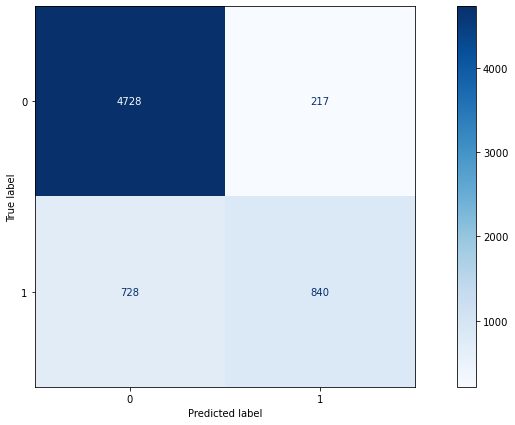

In [103]:
plot_cm(model_tree, X_validation, y_validation)

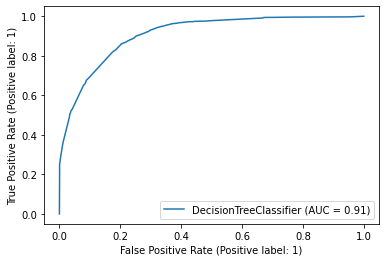

In [104]:
plot_roc_curve(model_tree, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento: con feature_engineering del tp1

Nuevamente obtenemos el dataset para entrenar nuestro modelo. A diferencia del preprocesado anterior, ahora aplicaremos el feature engineering obtenido del tp1:

In [105]:
X_fe_p1 = pr.preprocesado1(X)

Para entrenar el arbol necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **aplicar_OHE**:

In [106]:
pr.init_OHE(X_fe_p1)

In [107]:
X_ohe_p1 = pr.apply_OHE(X_fe_p1)

Realizamos la particion de nuestros datos en *train* y *validation*:

In [108]:
X_train_p1, X_validation_p1, y_train_p1, y_validation_p1 = train_test_split(X_ohe_p1,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con randomsearch. La metrica que se utiliza para comparar los modelos en cada iteracion es *roc_auc_score*:

In [109]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(40, 50),
}

clf = DecisionTreeClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.9032934535908351
Best params {'min_samples_leaf': 42, 'max_depth': 9, 'criterion': 'gini'}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [110]:
model_tree_p1 = gscv.best_estimator_

Entreno el modelo con el train set:

In [111]:
model_tree_p1.fit(X_train_p1, y_train_p1)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=42, random_state=19)

Predigo con el validation set:

In [112]:
tree_predict = model_tree_p1.predict(X_validation_p1)

**Metricas**

In [113]:
print(classification_report(y_validation_p1, tree_predict))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4945
           1       0.77      0.54      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.75      0.77      6513
weighted avg       0.85      0.85      0.84      6513



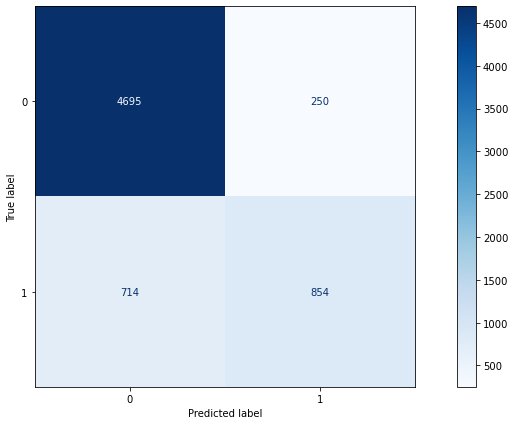

In [114]:
plot_cm(model_tree_p1, X_validation_p1, y_validation_p1)

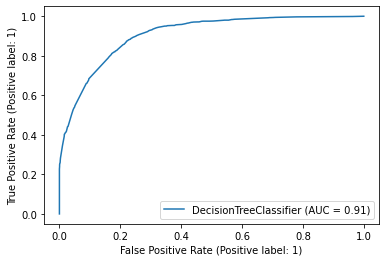

In [115]:
plot_roc_curve(model_tree_p1, X_validation_p1, y_validation_p1, response_method="predict_proba")
plt.show()

## Preprocesamiento 2:

Nuevamente obtenemos el dataset para entrenar nuestro modelo. A diferencia del preprocesado anterior, ahora aplicaremos el preprocesamiento 2 que consiste en generar nuevas columnas a partir de las que tenemos.:

In [116]:
X_fe_p2 = pr.preprocesado2(X)

Para entrenar el arbol necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **aplicar_OHE**:

In [117]:
pr.init_OHE(X_fe_p2)

In [118]:
X_ohe_p2 = pr.apply_OHE(X_fe_p2)

Realizamos la particion de nuestros datos en *train* y *validation*:

In [119]:
X_train_p2, X_validation_p2, y_train_p2, y_validation_p2 = train_test_split(X_ohe_p2,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con randomsearch. La metrica que se utiliza para comparar los modelos en cada iteracion es *roc_auc_score*:

In [120]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(40, 50),
}

clf = DecisionTreeClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.903714792505426
Best params {'min_samples_leaf': 47, 'max_depth': 9, 'criterion': 'gini'}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [121]:
model_tree_p2 = gscv.best_estimator_

Entreno el modelo con el train set:

In [122]:
model_tree_p2.fit(X_train_p2, y_train_p2)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=47, random_state=19)

Predigo con el validation set:

In [123]:
tree_predict = model_tree_p2.predict(X_validation_p2)

**Metricas**

In [124]:
print(classification_report(y_validation_p2, tree_predict))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4945
           1       0.78      0.54      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.75      0.77      6513
weighted avg       0.85      0.85      0.84      6513



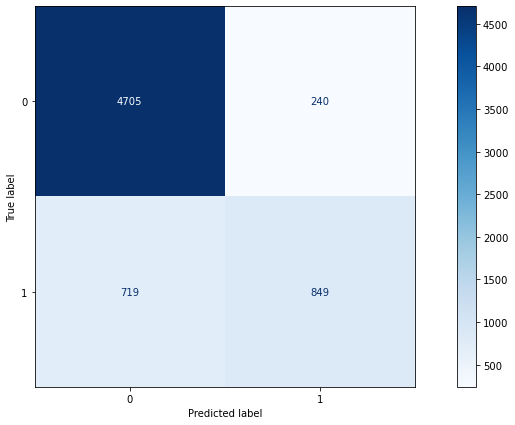

In [125]:
plot_cm(model_tree_p2, X_validation_p2, y_validation_p2)

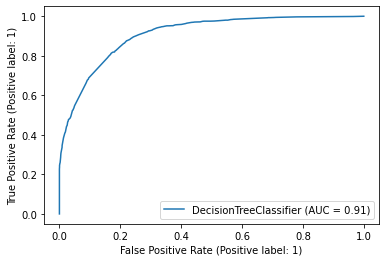

In [126]:
plot_roc_curve(model_tree_p2, X_validation_p2, y_validation_p2, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que no hay mucha diferencia entre el preprocesamiento 1 y el preprocesamiento 2. A su vez, vimos que entrenando el arbol con los datos sin realizar ningun preprocesamiento obtenemos un mejor resultado de AUC_ROC. Entonces nos quedaremos con el primer modelo:

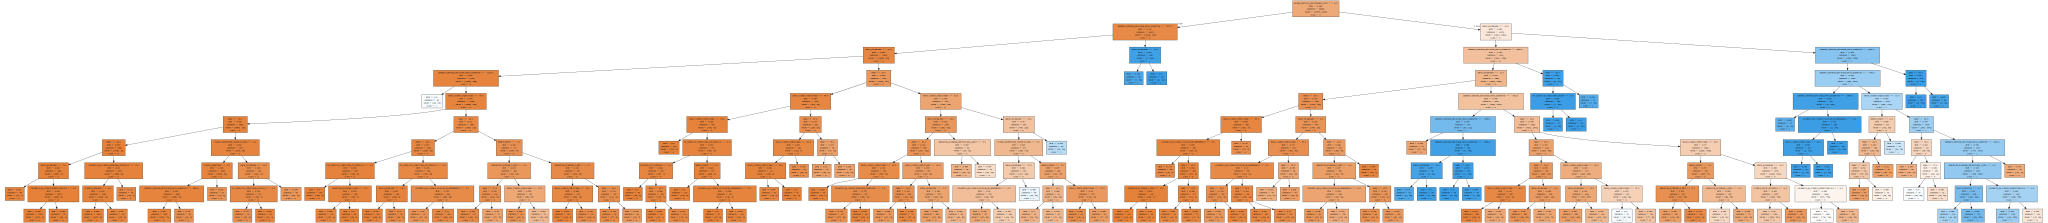

In [138]:
plot_tree(model_tree,X_train.columns)

# Predicción

In [128]:
ids, X_holdout = get_holdout_set(missings='category')

In [129]:
pr.init_OHE(X_fe_p1)

In [130]:
X_holdout_fe = pr.preprocesado1(X_holdout)

In [131]:
X_holdout_ohe = pr.apply_OHE(X_holdout_fe)

In [132]:
tree_predict = model_tree_p1.predict(X_holdout_ohe)

In [133]:
create_prediction(ids,tree_predict,file_name='arbol_desicion_prediction')